In [1]:
import torch
import torch.nn as nn

import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()        
        self.disc_model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.disc_model(x)        
        return x
        

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        
        self.res = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.res(x)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()        
        self.gen_model = nn.Sequential(
            
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen_model(x)


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [5]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from datetime import date
import os
import os.path

In [6]:
## Hyper Parameters
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
BATCH_SIZE = 64
DATALOADER_WORKER = 1
SHUFFLE_DATASET = True
IMG_SIZE = 256
NGPU = 3
NUM_EPOCHS = 5
lr = 2e-4
save_key = "real_image"
folder_key = "2"
beta1 = 0.5
save_folders = [f"weights/{folder_key}/{save_key}/gen/",f"weights/{folder_key}/{save_key}/disc/"]


In [7]:
for dir in save_folders:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [8]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
    )
training_data = dset.ImageFolder(
    root="pizza/realpizza",    
    transform=transform
)
dataloader = torch.utils.data.DataLoader(training_data,batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=DATALOADER_WORKER)
device = torch.device("cuda:0" if (torch.cuda.is_available() and NGPU > 0) else "cpu")

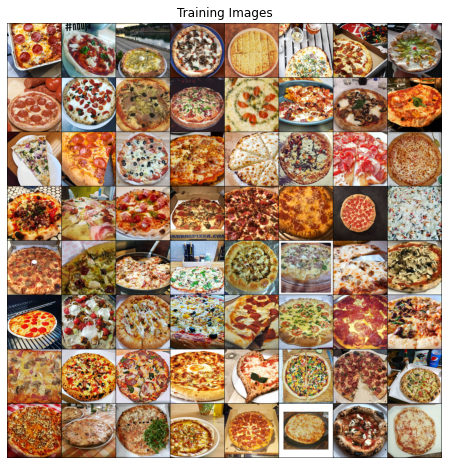

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [10]:
gen = Generator().to(device)
if (device.type == 'cuda') and (NGPU > 1):
    gen = nn.DataParallel(gen, list(range(NGPU)))
    
disc = Discriminator().to(device)
if (device.type == 'cuda') and (NGPU > 1):
    disc = nn.DataParallel(disc, list(range(NGPU)))
    
gen.apply(weights_init)
disc.apply(weights_init)

DataParallel(
  (module): Discriminator(
    (disc_model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [11]:
criterion = nn.MSELoss().to(device)
real_label = 1
fake_label = 0
optimizer_disc = optim.Adam(disc.parameters(),lr=lr,betas=(beta1,0.999))
optimizer_gen = optim.Adam(gen.parameters(),lr=lr,betas=(beta1,0.999))

In [12]:
img_list = []
G_losses = []
D_losses = []
iters = 0
fixed_noise = torch.randn(BATCH_SIZE, 3, 256, 256, device=device)

In [13]:
for epoch in range(NUM_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

       
       
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        real_label = torch.full((b_size, 1,30,30), 1, device=device, dtype=torch.float32)
        fake_label = torch.full((b_size, 1,30,30), 0, device=device, dtype=torch.float32)
        
        optimizer_gen.zero_grad()
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 3, 256, 256, device=device)
        # Generate fake image batch with G
        fake_img = gen(noise)
        fake_g_output = disc(fake_img)
        loss_g = criterion(fake_g_output,real_label)
        loss_g.backward()
        optimizer_gen.step()
        
        optimizer_disc.zero_grad()
        real_d_output = disc(real_img)
        loss_d_real = criterion(real_d_output,real_label)
        noise_d = torch.randn(b_size, 3, 256, 256, device=device)
        fake_d_output = disc(gen(noise_d).detach())
        loss_d_fake = criterion(fake_d_output,fake_label)
        
        loss_d = (loss_d_real+loss_d_fake)/2
        loss_d.backward()
        optimizer_disc.step()

        #Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, NUM_EPOCHS, i, len(dataloader),
                     loss_d.item(), loss_g.item()))

        # Save Losses for plotting later
        G_losses.append(loss_g.item())
        D_losses.append(loss_d.item())

        
        iters += 1
    with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake, padding=2, normalize=True)
    img_list.append(img_grid)
    torchvision.utils.save_image(img_grid,f"weights/{folder_key}/{save_key}/gen/img_epoch_{epoch}_{iter}.png")
    
    torch.save(gen.state_dict(), f"weights/{folder_key}/{save_key}/gen/gen_epoch_{epoch}.pth")
    torch.save(disc.state_dict(), f"weights/{folder_key}/{save_key}/disc/disc_epoch_{epoch}.pth")


[0/5][0/131]	Loss_D: 4.3120	Loss_G: 6.1432	
[0/5][10/131]	Loss_D: 0.7830	Loss_G: 1.0228	
[0/5][20/131]	Loss_D: 0.6923	Loss_G: 0.9107	
[0/5][30/131]	Loss_D: 0.4966	Loss_G: 0.9006	
[0/5][40/131]	Loss_D: 0.7010	Loss_G: 1.0337	
[0/5][50/131]	Loss_D: 0.3683	Loss_G: 0.7744	
[0/5][60/131]	Loss_D: 0.3594	Loss_G: 0.7851	
[0/5][70/131]	Loss_D: 0.4723	Loss_G: 0.8354	
[0/5][80/131]	Loss_D: 0.4468	Loss_G: 0.6961	
[0/5][90/131]	Loss_D: 0.5934	Loss_G: 0.7845	
[0/5][100/131]	Loss_D: 0.5014	Loss_G: 1.0827	
[0/5][110/131]	Loss_D: 0.3377	Loss_G: 0.5133	
[0/5][120/131]	Loss_D: 0.3080	Loss_G: 0.4769	
[0/5][130/131]	Loss_D: 0.2992	Loss_G: 0.4866	


NameError: name 'torchvision' is not defined

In [154]:
iters

777

In [22]:
from datetime import date
today = date.today()
d1 = today.strftime("%d_%m_%Y")
print("d1 =", d1)

d1 = 10_03_2022


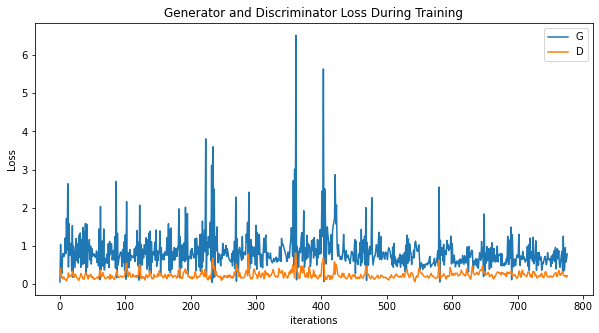

In [144]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

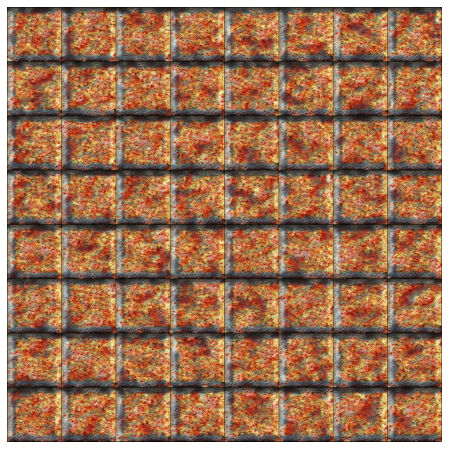

In [145]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

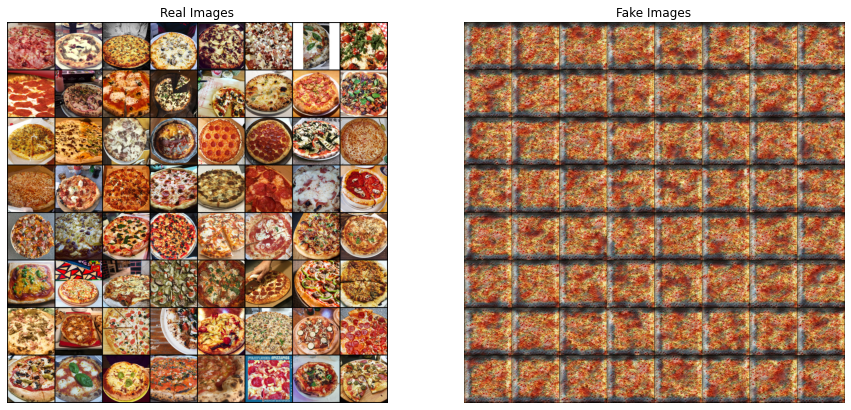

In [146]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [147]:
len(img_list)

3

In [153]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(img_list[0]))
plt.show()

In [171]:
for i in range(len(img_list)):
    plt.savefig(str(i)+'.png', img_list[0])

TypeError: savefig() takes 2 positional arguments but 3 were given

<Figure size 432x288 with 0 Axes>

In [173]:
import torchvision
for i,img in enumerate(img_list):
    torchvision.utils.save_image(img,str(i)+'.png')